<a href="https://colab.research.google.com/github/amadousysada/scoring-model/blob/master/04_explication_resultats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [211]:
!pip install lime

In [212]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

In [213]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import pickle
import time
import random

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Scikit Learn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, auc, make_scorer, confusion_matrix, fbeta_score, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import ColumnTransformer

# Modèles de Boosting
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Imblearn, pour le réequilibrage
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# LIME & SHAP
from lime.lime_tabular import LimeTabularExplainer
import shap

In [214]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve vos cvs.

In [215]:
X_train = pd.read_csv(f"{folder_path}final_cleaned_app_train.csv")
X_test = pd.read_csv(f"{folder_path}final_cleaned_app_test.csv")

Y = X_train['TARGET']

X_train.drop(columns=['SK_ID_CURR', 'TARGET'], inplace=True)
X_test.drop(columns=['SK_ID_CURR'], inplace=True)

In [216]:
# Recuperer mon modéle
with open(f"{folder_path}final_model.pkl", "rb") as f:
    pipeline = pickle.load(f)
pipeline.predict

<bound method Pipeline.predict of Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('smote',
                 SMOTE(k_neighbors=2, random_state=42, sampling_strategy=0.15)),
                ('clf',
                 LGBMClassifier(learning_rate=0.23633681163831163, max_depth=5,
                                min_data_in_leaf=88, n_estimators=119,
                                n_jobs=-1, num_leaves=53, random_state=42,
                                scale_pos_weight=3.6939763969235964))])>

In [217]:
lgbm = pipeline.named_steps["clf"]  # Accéder au modèle RandomForest

In [218]:
# Le seuil minimum retenu lors de la modélisation
threshold = 0.28

In [219]:
# Predict
X_test = SimpleImputer(strategy="median").fit_transform(X_test)

y_pred_proba = lgbm.predict_proba(X_test, verbosity=-1)[:, 1]
y_preds = (y_pred_proba > threshold).astype(int)

# Explications via les scores d'importance des caractéristiques [Modèles basés sur les arbres]

Les modèles basés sur les arbres possèdent des propriétés qui permettent d'inférer l'importance d'une caractéristique. Pour chaque arbre de décision, on peut calculer la diminution moyenne de l'impureté pour chaque caractéristique, c’est-à-dire l’impact de la caractéristique sur la réduction de l’incertitude (classificateurs) ou de la variance (régressions) des prédictions de l’arbre de décision. Cette valeur est également connue sous le nom de score d’importance de Gini. Pour notre modèle **lightGBM** basé sur les arbres, nous pouvons utiliser l'implémentation `feature_importance` de sklearn et visualiser l'importance moyenne de chaque variable.

In [220]:
# importance des variables
coef_imp_feature = pd.DataFrame({'variable': X_train.columns,
                                 'coef': lgbm.feature_importances_})
print(coef_imp_feature.sort_values(by='coef', ascending=False))

                                             variable  coef
13                            ANNUITY_TO_CREDIT_RATIO   451
30                                         DAYS_BIRTH   242
24                                PREV_APP_DEBT_RATIO   225
28                             DAYS_LAST_PHONE_CHANGE   224
19                                         AMT_CREDIT   209
7                          REGION_POPULATION_RELATIVE   209
11                                        AMT_ANNUITY   199
22                                    DAYS_ID_PUBLISH   199
15                                         TOTAL_DEBT   194
2                             HOUR_APPR_PROCESS_START   116
29                                      CODE_GENDER_F   113
3                            OBS_30_CNT_SOCIAL_CIRCLE   107
1                                     CNT_FAM_MEMBERS   101
16                             REG_CITY_NOT_WORK_CITY    93
21                               REGION_RATING_CLIENT    89
18                                      

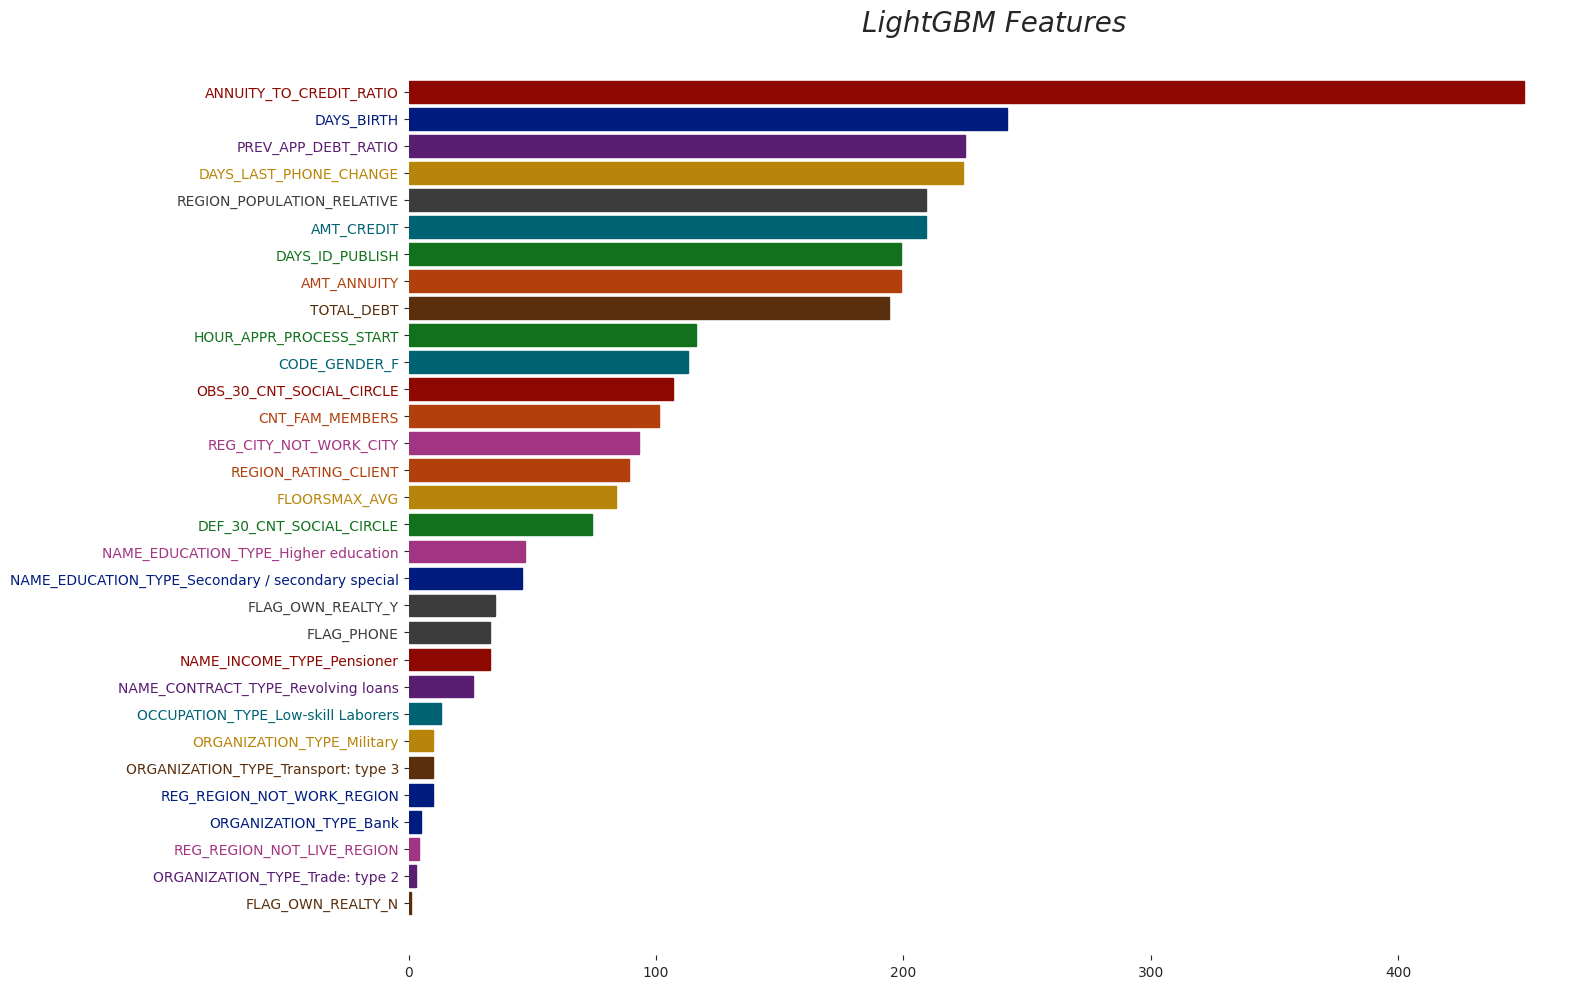

In [221]:
sns.set_style("ticks")
features = X_train.columns
color_list =  sns.color_palette("dark", len(features))

feature_importance = lgbm.feature_importances_
feature_imp_df = pd.DataFrame(sorted(zip(feature_importance, features)), columns=['Value','Feature'])

fig, ax = plt.subplots(1, 1, figsize=(16, 10))

indices = np.argsort(feature_importance)

plt.sca(ax)
plt.yticks(range(len(indices)), [features[j] for j in indices], fontweight="normal", fontsize=10)

for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(color_list[indices[i]])

bars = ax.barh(range(len(indices)), feature_importance[indices], color='b', align='center')
for i,bar in enumerate(bars):
  bar.set_color(color_list[indices[i]])
  plt.box(False)
plt.title('LightGBM Features', fontsize=20, fontstyle='italic')
plt.tight_layout()
plt.show()

Ces valeurs d’importance des caractéristiques semblent intéressantes. Le modèle classe les 10 variables `ANNUITY_TO_CREDIT_RATIO`, `YEARS_BEGINEXPLUATATION_AVG`, `EXT_SOURCE_2`, `EXT_SOURCE_3`, `DAYS_BIRTH`, `AMT_CREDIT`, `PREV_APP_DEBT_RATIO`, `AMT_ANNUITY`, `TOTAL_DEBT` et `DAYS_ID_PUBLISH` parmi les 10 caractéristiques les plus pertinentes, ce qui suggère qu’elles sont importantes.

Cependant, il existe plusieurs limites :  
- Les scores d’importance des caractéristiques sont relatifs, ce qui rend leur interprétation difficile par rapport au résultat prédit. Par exemple, bien qu’ils indiquent que `DAYS_BIRTH` est relativement plus important que `AMT_CREDIT` dans le modèle, ils ne précisent pas dans quelle mesure un client plus agé risque plus ou moins de ne pas remboursé son pret.  
- Les mesures d’importance des caractéristiques sont des estimations globales sur l’ensemble du jeu de données d’entraînement. Pour un sous-ensemble de clients, au sein du même modèle, l’ordre et l’amplitude de l’importance des caractéristiques peuvent changer. Ainsi, bien que nous sachions que `DAYS_BIRTH` est important en moyenne, nous ne pouvons pas répondre avec certitude à la question suivante : comment `DAYS_BIRTH` affecte-t-il un client spécifique ?

# Explications via **LIME**(Local Interpretable Model-agnostic Explanation)

LIME offre une méthode rapide et relativement simple pour expliquer localement les modèles de type "boîte noire". L'algorithme LIME peut être simplifié en quelques étapes :

1. Pour un point de données donné, perturber ses caractéristiques de manière aléatoire à plusieurs reprises. Pour des données tabulaires, cela consiste à ajouter une petite quantité de bruit à chaque caractéristique.  
2. Obtenir les prédictions pour chaque instance de données perturbée. Cela permet de construire une image locale de la surface de décision à ce point.  
3. Utiliser les prédictions pour calculer un "modèle explicatif" linéaire approximatif. Les coefficients de ce modèle linéaire sont utilisés comme explications.  

La bibliothèque Python LIME fournit des interfaces pour expliquer les modèles construits sur des données tabulaires (`TabularExplainer`), des images (`LimeImageExplainer`) et des textes (`LimeTextExplainer`).

In [223]:
scaler = StandardScaler()
feat_names = list(X_train.columns)
data = pd.DataFrame(SimpleImputer(strategy="median").fit_transform(X_train), columns=X_train.columns)

def get_lime_explainer(data, labels):
  feat_names = list(data.columns)
  class_names = ["Non defaut", "Defaut"]
  data = scaler.fit_transform(data)
  lime_explainer = LimeTabularExplainer(data, feature_names=feat_names, class_names=class_names, mode="classification")

  return lime_explainer

def lime_explain(explainer, data, num_features):
  explanation = explainer.explain_instance(data, lgbm.predict_proba, num_features=num_features)
  return explanation


def explain_instance(test_data_index, lime_explainer, top_x=19):
  lime_data_explainations = []

  explanation = lime_explain(lime_explainer, X_test[test_data_index], top_x)

  ex_holder = {}
  for feat_index,ex in explanation.as_map()[1] :
    ex_holder[feat_names[feat_index]] = ex

  lime_data_explainations.append(ex_holder)
  actual_pred = lgbm.predict_proba(X_test[test_data_index].reshape(1,-1), verbosity=-1)
  perc_pred_diff =  abs(actual_pred[0][1] - explanation.local_pred[0])
  lime_metrics = [{"prediction de LIME -> 1": explanation.local_pred[0], "prediction model -> 1": actual_pred[0][1], "class_diff": round(perc_pred_diff,3), "model": "LightGBM" }]

  return lime_data_explainations, lime_metrics, explanation

top_x = 10
lime_explainer = get_lime_explainer(data, Y)

In [224]:
def plot_lime_exp(exp_data, title):
  features =  list(exp_data.keys())[::-1]
  explanations = list(exp_data.values())[::-1]
  fig, ax = plt.subplots()
  lime_bar = ax.barh( features, explanations )
  ax.set_title(title, fontsize = 20)
  for i,bar in enumerate(lime_bar):
    bar.set_color(color_list[list(features).index(features[i])])
    plt.box(False)

In [225]:
y_preds = lgbm.predict(X_test, verbosity=-1)

## Explication d'une instance default: prediction = 1

23881


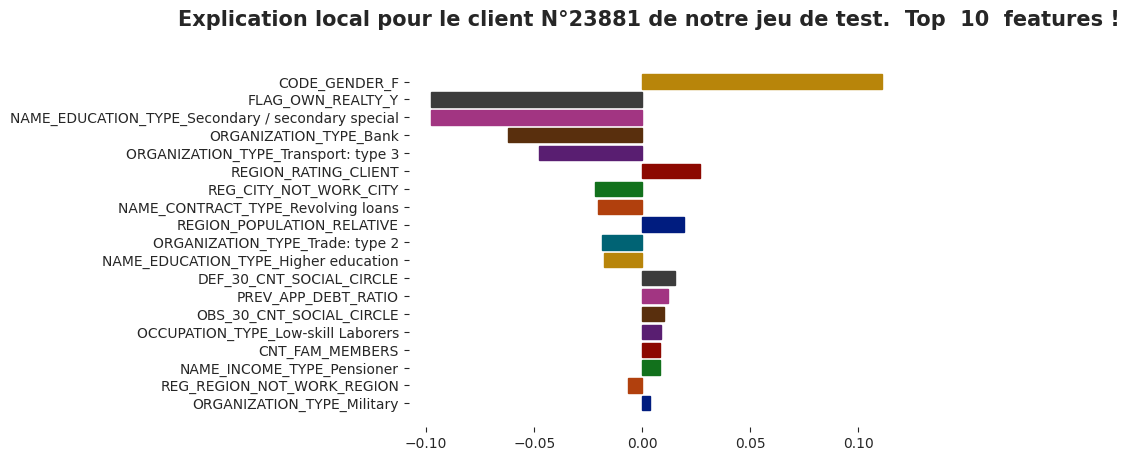

In [226]:
# Expliquer un client qui presente un defaut
warnings.filterwarnings("ignore", category=UserWarning)

true_preds = np.argwhere((y_preds == 1) & (y_pred_proba > 0.55)).flatten()

idx  = random.choice(true_preds)
#idx = 41763
print(idx)

lime_data_explainations, lime_metrics, explanation = explain_instance(idx, lime_explainer)
plot_lime_exp(lime_data_explainations[0], "")
plt.suptitle( f"Explication local pour le client N°{idx} de notre jeu de test.  Top  {top_x}  features !", fontsize=15, fontweight="bold")
plt.show()

In [227]:
pd.DataFrame(lime_data_explainations)

CODE_GENDER_F  FLAG_OWN_REALTY_Y  \
0       0.111008          -0.097605   

   NAME_EDUCATION_TYPE_Secondary / secondary special  ORGANIZATION_TYPE_Bank  \
0                                          -0.097605               -0.061992   

   ORGANIZATION_TYPE_Transport: type 3  REGION_RATING_CLIENT  \
0                            -0.047891              0.026561   

   REG_CITY_NOT_WORK_CITY  NAME_CONTRACT_TYPE_Revolving loans  \
0               -0.021628                           -0.020355   

   REGION_POPULATION_RELATIVE  ORGANIZATION_TYPE_Trade: type 2  \
0                    0.019118                        -0.018824   

   NAME_EDUCATION_TYPE_Higher education  DEF_30_CNT_SOCIAL_CIRCLE  \
0                             -0.017682                  0.015289   

   PREV_APP_DEBT_RATIO  OBS_30_CNT_SOCIAL_CIRCLE  \
0             0.011727                  0.010048   

   OCCUPATION_TYPE_Low-skill Laborers  CNT_FAM_MEMBERS  \
0                            0.008851         0.008304   

   NAME_INCOME_TYPE_Pensioner  REG_REGION_NOT_WORK_REGION  \
0                    0.008015                   -0.006636   

   ORGANIZATION_TYPE_Military  
0                    0.003402

In [228]:
explanation.show_in_notebook()

**NAME_EDUCATION_TYPE_Secondary / secondary special:** 0.28226884489950366
Cela signifie que l'éducation secondaire / secondaire spécialisée a un impact positif sur la probabilité d'être classé dans la classe "1" (le défaut de crédit dans ce cas). Plus précisément, la valeur de cette caractéristique augmente la probabilité d'un défaut de crédit d'environ 0.282.

**FLAG_OWN_CAR_Y**: -0.27635074547313915
A l'inverse, le fait de posséder une voiture (**FLAG_OWN_CAR_Y**) a un impact négatif. Cela signifie que posséder une voiture réduit la probabilité de défaut de crédit d'environ 0.276. Si cette caractéristique est positive (indiquant qu'une personne possède une voiture), le modèle est moins susceptible de prédire un défaut de crédit.

**EXT_SOURCE_2**: 0.15349581018435896
La caractéristique '**EXT_SOURCE_2**', qui peut être une source externe (comme un score de crédit externe), a également un impact positif. Cela suggère qu'un score élevé dans cette source augmente la probabilité de défaut de crédit.

**CODE_GENDER_F**: -0.1337548535482004
Le genre féminin a un impact négatif sur la probabilité de défaut de crédit, c'est-à-dire que les individus féminins sont moins susceptibles de faire défaut, avec une réduction d'environ 0.134 sur la probabilité.


PREV_APP_DEBT_RATIO: -0.05450345716216374
Le ratio d'endettement précédent a un effet négatif mais relativement faible sur la probabilité de défaut de crédit. En d'autres termes, un ratio d'endettement plus élevé réduit légèrement le risque de défaut.



- Les caractéristiques ayant un poids positif sur la prédiction de la classe 1 (défaut de crédit) sont : **NAME_EDUCATION_TYPE_Secondary / secondary special**, **EXT_SOURCE_2**, **EXT_SOURCE_3**.
- Les caractéristiques ayant un poids négatif sur la prédiction de la classe 1 (réduction de la probabilité de défaut) sont : **FLAG_OWN_CAR_Y**, **CODE_GENDER_F**, **PREV_APP_DEBT_RATIO**, **YEARS_BEGINEXPLUATATION_AVG**, **DAYS_BIRTH**, et **TOTAL_DEBT**.

In [229]:
display(pd.DataFrame(lime_metrics))

prediction de LIME -> 1  prediction model -> 1  class_diff     model
0                 0.707306               0.609701       0.098  LightGBM

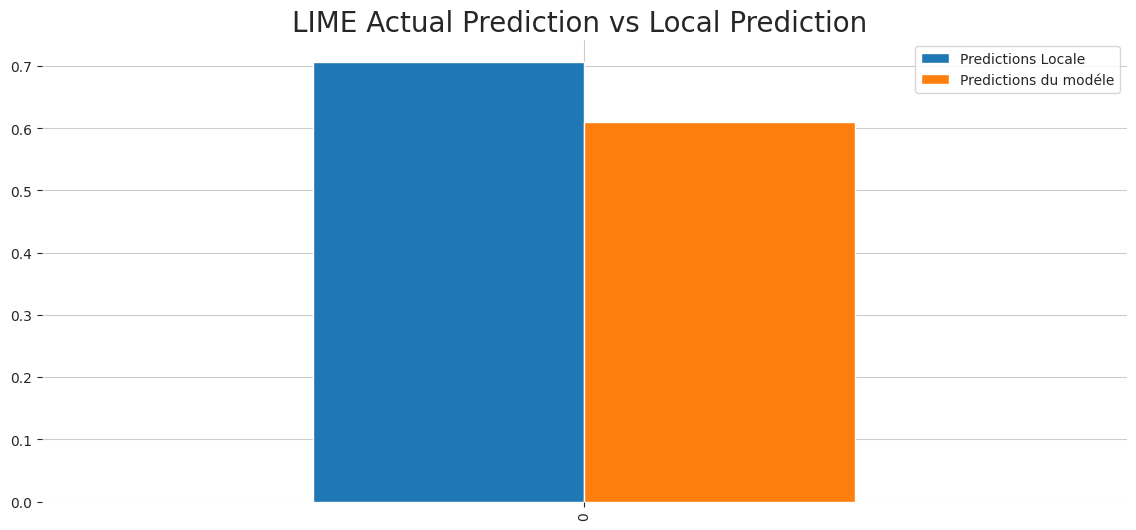

In [230]:
lime_metrics_df = pd.DataFrame(lime_metrics)
lime_metrics_df_ax = lime_metrics_df[["prediction de LIME -> 1", "prediction model -> 1", "model"]].plot(kind="bar", title="LIME Actual Prediction vs Local Prediction ", figsize=(14,6))
lime_metrics_df_ax.title.set_size(20)
lime_metrics_df_ax.legend(["Predictions Locale", "Predictions du modéle"])
plt.box(False)
plt.grid(True)

- Prédiction LIME (0.680975	) : LIME prédit qu'il y a environ 68% de probabilité que l'instance corresponde à la classe "1", ce qui, dans le contexte du risque de défaut de crédit, signifie une probabilité de défaut de crédit (par exemple, l'individu risque de ne pas rembourser son crédit).

- Prédiction du modèle réel (LightGBM) (0.963244) : Le modèle LightGBM prédit que la probabilité de défaut de crédit est de 96% pour cette même instance.

- Différence entre les prédictions (0.28) : La différence entre la prédiction fournie par LIME et celle du modèle réel est d'environ 28%. Cela signifie que la prédiction de LIME est légèrement inférieure à celle du modèle réel de LightGBM pour cette instance spécifique.

La différence de 28% indique qu'il existe une légère discréance entre la manière dont LIME interprète la décision du modèle (LightGBM) et la prédiction réelle de ce modèle.
Le modèle réel prévoit un risque de défaut de crédit plus élevé (96%) pour cette instance par rapport à l'explication locale fournie par LIME (68%).
LIME, en tant que modèle d'explication, simplifie la décision du modèle de manière locale, ce qui peut expliquer la différence.

## Explication d'une instance non defaut: prediction = 0

31451


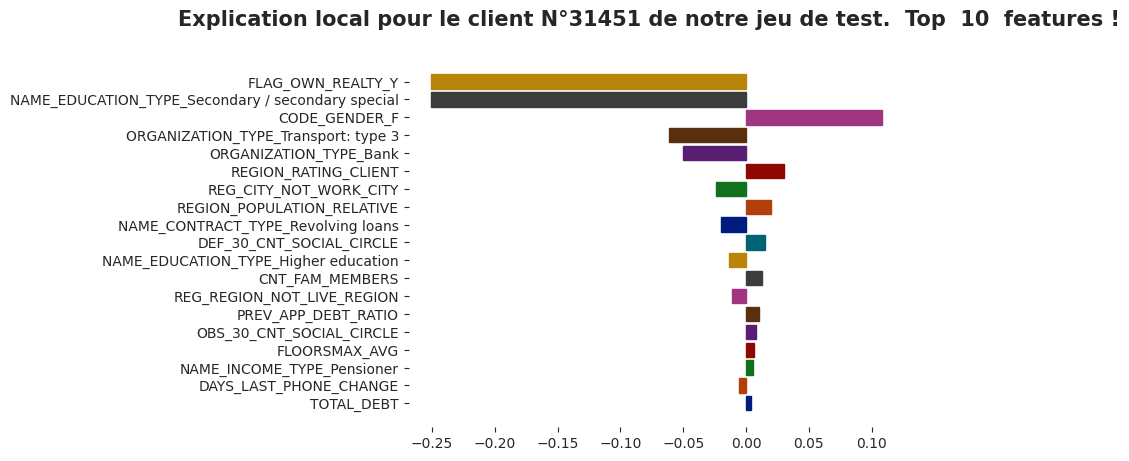

In [231]:
# Expliquer un client fiable
warnings.filterwarnings("ignore", category=UserWarning)

true_preds = np.argwhere((y_preds == 0).flatten())

#idx  = random.choice(true_preds)[0]
idx = 31451
print(idx)

lime_data_explainations, lime_metrics, explanation = explain_instance(idx, lime_explainer)
plot_lime_exp(lime_data_explainations[0], "")
plt.suptitle( f"Explication local pour le client N°{idx} de notre jeu de test.  Top  {top_x}  features !", fontsize=15, fontweight="bold")
plt.show()

In [232]:
explanation.show_in_notebook()

In [233]:
pd.DataFrame(lime_data_explainations)

FLAG_OWN_REALTY_Y  NAME_EDUCATION_TYPE_Secondary / secondary special  \
0          -0.250639                                          -0.250639   

   CODE_GENDER_F  ORGANIZATION_TYPE_Transport: type 3  ORGANIZATION_TYPE_Bank  \
0       0.108378                            -0.060964               -0.049825   

   REGION_RATING_CLIENT  REG_CITY_NOT_WORK_CITY  REGION_POPULATION_RELATIVE  \
0              0.030356               -0.023602                    0.019868   

   NAME_CONTRACT_TYPE_Revolving loans  DEF_30_CNT_SOCIAL_CIRCLE  \
0                           -0.019624                  0.015132   

   NAME_EDUCATION_TYPE_Higher education  CNT_FAM_MEMBERS  \
0                              -0.01373         0.012345   

   REG_REGION_NOT_LIVE_REGION  PREV_APP_DEBT_RATIO  OBS_30_CNT_SOCIAL_CIRCLE  \
0                   -0.011402             0.010106                  0.007956   

   FLOORSMAX_AVG  NAME_INCOME_TYPE_Pensioner  DAYS_LAST_PHONE_CHANGE  \
0       0.005947                    0.005784                 -0.0054   

   TOTAL_DEBT  
0     0.00361

- **FLAG_OWN_CAR_Y** : -0.26422
La possession d'une voiture est négativement associée à la probabilité de défaut de crédit. Ici, une valeur négative suggère que l'individu est moins susceptible de faire défaut si ce dernier possède une voiture. Cela indique un comportement financier plus fiable dans ce cas précis.

- **EXT_SOURCE_2** : -0.167091
La caractéristique 'EXT_SOURCE_2' semble également jouer un rôle négatif. Cette source externe pourrait être un score de crédit ou un indicateur financier supplémentaire. Un score plus faible dans cette source externe peut être associé à un faible risque de défaut.

- **CODE_GENDER_F** : -0.127046
Le fait que l'individu soit de genre féminin a également un effet négatif, réduisant légèrement la probabilité de défaut de crédit.

- **NAME_EDUCATION_TYPE_Secondary / secondary special** : 0.101561
L'éducation secondaire ou spécialisée a un impact positif, augmentant la probabilité de défaut de crédit, mais de manière faible dans ce cas. Cela pourrait être une caractéristique associée à un facteur externe lié à l'éducation, mais l'impact ici est relativement faible par rapport aux autres variables.

- **DAYS_BIRTH** : -0.050059
L'âge de l'individu, exprimé en nombre de jours depuis la naissance, a un impact négatif. Les personnes plus âgées sont généralement perçues comme moins risquées d'un point de vue financier, ce qui est confirmé ici avec cette valeur négative.



- **YEARS_BEGINEXPLUATATION_AVG**' : 0.030306
L'expérience professionnelle moyenne est légèrement positive. Cela peut indiquer que les individus avec moins d'expérience professionnelle ont un risque légèrement plus élevé, bien que l'effet soit faible dans ce cas.

- **TOTAL_DEBT** : -0.026628
La dette totale a un impact négatif, ce qui est attendu car une dette plus faible suggère un risque réduit de défaut de crédit.

- **ANNUITY_TO_CREDIT_RATIO** : 0.0259
Le ratio de l'annuité par rapport au crédit est légèrement positif, suggérant qu'une valeur plus élevée de ce ratio pourrait être associée à un léger risque accru de défaut.

- **AMT_ANNUITY** : -0.016842
Le montant de l'annuité est légèrement négatif, ce qui signifie qu'un montant d'annuité plus élevé est associé à une probabilité légèrement réduite de défaut de crédit.

# Explications via **SHAP**

In [234]:
scaled_train_data = StandardScaler().fit_transform(SimpleImputer(strategy="median").fit_transform(X_train))
sub_sampled_train_data = shap.sample(scaled_train_data, 600, random_state=42) # utiliser 600 observations comme données background pour shap

subsampled_test_data = shap.sample(X_test, 10, random_state=42)

explainer = shap.Explainer(lgbm)
shap_values = explainer.shap_values(subsampled_test_data)

In [235]:
shap.initjs()
pred_ind = 7
shap.force_plot(explainer.expected_value, shap_values[pred_ind], subsampled_test_data[pred_ind], feature_names=X_train.columns)

Pour une meilleure interpretation le log-odds peut être converti en probabilité avec la sigmoïde :

𝑃(x) = 1/(1+𝑒−(x))

In [236]:
# Calcul de probas

base_value = explainer.expected_value
log_odds_prediction = base_value + shap_values[pred_ind].sum()

prediction_proba_base = 1 / (1 + np.exp(-base_value))
prediction_proba_final = 1 / (1 + np.exp(-log_odds_prediction))


print(f"La probabilité que l'individu N°{pred_ind} soit classée comme defaillant est de: {prediction_proba_final*100:.1f}%")

La probabilité que l'individu N°7 soit classée comme defaillant est de: 19.3%


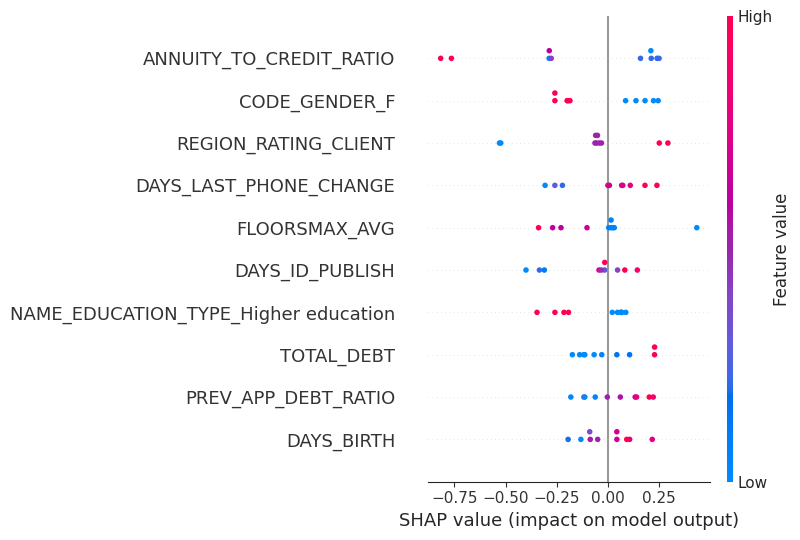

In [237]:
shap.initjs()
shap.summary_plot(shap_values, subsampled_test_data, feature_names=X_train.columns, max_display=10)

**FIN**